# Chess classification

- using CNN architecture
- challenges : image dataset doesnt have format and ukuran yang seragam
- we use ImageDataGenerator to solve it

1. download and import dataset

In [ ]:
    !wget --no-check-certificate \
        https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip \
        -O /tmp/Chessman-image-dataset.zip

--2022-03-30 05:51:17--  https://github.com/dicodingacademy/assets/raw/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip [following]
--2022-03-30 05:51:17--  https://raw.githubusercontent.com/dicodingacademy/assets/main/ml_pengembangan_academy/Chessman-image-dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60684125 (58M) [application/zip]
Saving to: ‘/tmp/Chessman-image-dataset.zip’

/tmp/Chessman-image 100%[===================>]  57.87M   195MB/s    in 

2. extract zip file to /tmp

In [ ]:
    import os
    import zipfile
    local_zip = '/tmp/Chessman-image-dataset.zip'
    zip_ref = zipfile.ZipFile(local_zip, 'r')
    zip_ref.extractall('/tmp')
    zip_ref.close()

## Data exploration

- check directory

- Gunakan fungsi listdir dari kelas os untuk melihat direktori yang terdapat pada dataset. Dapat kita lihat bahwa terdapat 6 buah direktori pada dataset. Setiap direktori berisi gambar pion catur sesua dengan nama direktorinya.

In [ ]:
    os.listdir('/tmp/Chessman-image-dataset/Chess')

['Bishop', 'Rook', 'Knight', 'King', 'Pawn', 'Queen']

- calculate number of files in each directory datasets

In [ ]:
    print('total pawn images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Pawn')))
    print('total King images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/King')))
    print('total Knight images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Knight')))

    print('total Bishop images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Bishop')))
    print('total Rook images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Rook')))
    print('total Queen images :', len(os.listdir('/tmp/Chessman-image-dataset/Chess/Queen')))

total pawn images : 107
total King images : 76
total Knight images : 106
total Bishop images : 87
total Rook images : 102
total Queen images : 78


-  Dari output dapat dilihat bahwa jumlah sampel pada tiap direktori berbeda. Perlu diperhatikan juga dataset ini berukuran sangat kecil sehingga performa dari model mungkin tidak akan terlalu baik. Kita akan mencoba menggunakan augmentasi gambar untuk mengatasi masalah ini.

- we can show image example of datasets

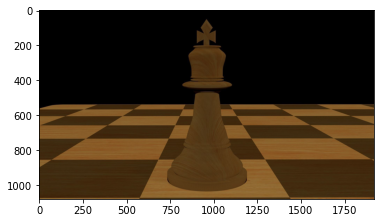

In [ ]:
    from keras.preprocessing import image
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    %matplotlib inline
    img = image.load_img('/tmp/Chessman-image-dataset/Chess/King/00000145.png')
    imgplot = plt.imshow(img)

## Data preparation

4. Next, we apply image augmentation to our datasets **to solve limited data**

In [ ]:
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
     
    train_dir = os.path.join('/tmp/Chessman-image-dataset/Chess')
    train_datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=20,
        zoom_range=0.2,
        shear_range=0.2,
        fill_mode = 'nearest',
        validation_split=0.1) # set validation split 10% data testing

- our dataset only consist of 1 directory and doesnt split into directory training & testing.
- but calm down, with ``ImageDataGenerator`` we doesnt need susah payah to split directory manually. cukup dengan ``validation_split``.
- we only tell dataTraining and dataTesting by add ``subset`` parameter with values ``training`` and ``validation``

In [ ]:
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=8,
        class_mode='categorical',
        subset='training') # set as training data
    validation_generator = train_datagen.flow_from_directory(
        train_dir, # same directory as training data
        target_size=(150, 150),
        batch_size=16,
        class_mode='categorical',
        subset='validation')

Found 499 images belonging to 6 classes.
Found 52 images belonging to 6 classes.


## Build Model

5. Next, we make model architecture. 

- 3 convolution layers 
  - after Convolution -> MaxPooling to decrease image resolution 
- 2 hidden layers


In [ ]:
    import tensorflow as tf
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),  
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.4),  
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(6, activation='softmax')  
    ])

- before model ready to train. it need several setting again. this add in compile stage

In [ ]:
    model.compile(optimizer=tf.optimizers.Adam(),
                  loss='categorical_crossentropy',
                  metrics = ['accuracy'])

- start training model

In [ ]:
    history = model.fit(train_generator,
                                  validation_data=validation_generator,
                                  epochs=50,
                                  verbose=2)

Epoch 1/50
63/63 - 35s - loss: 1.8103 - accuracy: 0.1603 - val_loss: 1.7859 - val_accuracy: 0.1923 - 35s/epoch - 550ms/step
Epoch 2/50
63/63 - 34s - loss: 1.7878 - accuracy: 0.2004 - val_loss: 1.7832 - val_accuracy: 0.1923 - 34s/epoch - 537ms/step
Epoch 3/50
63/63 - 33s - loss: 1.7861 - accuracy: 0.1844 - val_loss: 1.7811 - val_accuracy: 0.1923 - 33s/epoch - 525ms/step
Epoch 4/50
63/63 - 33s - loss: 1.7824 - accuracy: 0.2004 - val_loss: 1.7838 - val_accuracy: 0.2500 - 33s/epoch - 525ms/step
Epoch 5/50
63/63 - 33s - loss: 1.7701 - accuracy: 0.2124 - val_loss: 1.7756 - val_accuracy: 0.1923 - 33s/epoch - 524ms/step
Epoch 6/50
63/63 - 33s - loss: 1.7475 - accuracy: 0.2345 - val_loss: 1.8094 - val_accuracy: 0.2308 - 33s/epoch - 524ms/step
Epoch 7/50
63/63 - 33s - loss: 1.7358 - accuracy: 0.2224 - val_loss: 1.7580 - val_accuracy: 0.2115 - 33s/epoch - 525ms/step
Epoch 8/50
63/63 - 33s - loss: 1.7034 - accuracy: 0.2725 - val_loss: 1.8139 - val_accuracy: 0.1923 - 33s/epoch - 524ms/step
Epoch 9/

- Show graph Loss and Accuray of trained model

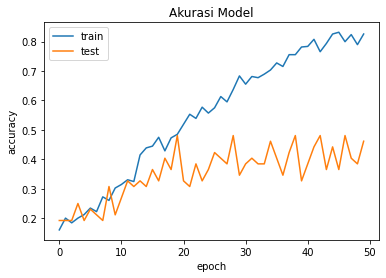

In [ ]:
    import matplotlib.pyplot as plt
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Akurasi Model')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

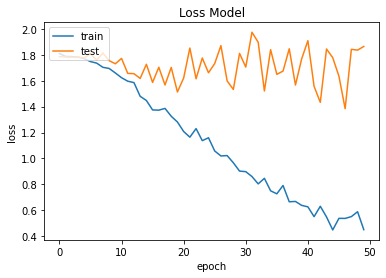

In [ ]:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss Model')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


- our validation accuration still bad
- we will solve this using transfer learning 